Importing libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
import shutil
from mne.preprocessing import annotate_amplitude

In [2]:
#a quick check of the raw data
raw_data_path = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_dataset/sub-001/eeg/sub-001_task-eyesclosed_eeg.set"

raw_data = mne.io.read_raw_eeglab(raw_data_path, preload=True)

print (raw_data.info)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>


In [3]:
#taking a subset of the data 4 subjects for healthy, 4 for alzheimer

source_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_dataset"
target_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short"


subject_ids = list(range(1, 5)) + list(range(37, 41))  # 4 subjects from healthy and 4 from alzheimer

# Loop through the selected subject IDs
for subject_id in subject_ids:
    subject_folder = f"sub-{str(subject_id).zfill(3)}"  # Format to sub-001, sub-002, etc.
    source_path = os.path.join(source_folder, subject_folder, "eeg", f"{subject_folder}_task-eyesclosed_eeg.set")

    
    if os.path.exists(source_path): # this checks if the source file exists
        shutil.copy(source_path, target_folder)  # this copies the file to the target folder
    else:
        print(f"File not found: {source_path}")


Signal Analysis

In [4]:
import glob
subject_path = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short"
set_files = glob.glob(f"{subject_path}/*.set")
filtered_output_preprocessed = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short"

In [5]:
def preprocess_file(set_path, output_path, n_components=19, noise_threshold=30e-6):
    """
    Preprocess an EEG file with optional noise detection, ICA, and ASR.

    Parameters:
    - set_path: Path to the input .set file.
    - output_path: Path to save the preprocessed file.
    - n_components: Number of components for ICA (default is 15).
    - noise_threshold: Noise threshold in volts (default is 30 µV, converted to volts).
    """
    print(f"Processing file: {set_path}")

    # Load the .set file
    raw_dataset = mne.io.read_raw_eeglab(set_path, preload=True)

    # Re-referencing using the common average referencing
    print("Applying average re-referencing...")
    raw_dataset.set_eeg_reference(ref_channels="average")

    # Apply band-pass filtering
    print("Applying band-pass filter 0.5Hz to 45Hz...")
    raw_dataset.filter(l_freq=0.5, h_freq=45)

    # Check for noise in the signal
    print("Checking for noise in the data...")
    # Compute standard deviation for each channel
    channel_stds = raw_dataset.get_data().std(axis=1)
    max_std = channel_stds.max()

    # If noise detected, apply ICA
    if max_std > noise_threshold:
        print(f"Noise detected! Maximum channel std: {max_std:.2e} V. Applying ICA...")

        # Perform ICA to remove artifacts
        ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, max_iter="auto")
        ica.fit(raw_dataset)

        # Plot ICA components for manual inspection (optional)
        ica.plot_components()

        # Automatically exclude artifacts (if desired, or manually exclude specific components)
        ica.exclude = []  
        raw_dataset = ica.apply(raw_dataset)

    else:
        print(f"No significant noise detected (max std: {max_std:.2e} V). Skipping ICA.")

    # Apply ASR for automatic artifact rejection
    print("Applying Artifact Subspace Reconstruction (ASR)...")

    # Annotate bad segments based on the amplitude threshold
    annotations, _ = annotate_amplitude(
        raw_dataset,
        peak=17e-6,  # ASR threshold: 17 µV converted to volts
        min_duration=0.5,  # Minimum artifact duration (0.5 seconds)
    )

    # Apply annotations
    raw_dataset.set_annotations(annotations)

    # Exclude bad segments manually
    print("Excluding bad segments...")
    good_data = raw_dataset.get_data()
    for annotation in raw_dataset.annotations:
        onset_sample = int(annotation['onset'] * raw_dataset.info['sfreq'])
        duration_sample = int(annotation['duration'] * raw_dataset.info['sfreq'])
        good_data[:, onset_sample:onset_sample + duration_sample] = np.nan  # Mark bad segments as NaN

    # omitting bad segments
    raw_dataset_clean = raw_dataset.copy()
    raw_dataset_clean._data = np.nan_to_num(good_data, nan=0.0)  # Replacing the Nans with zeroes

    # Save the preprocessed file
    output_file = os.path.join(output_path, os.path.basename(set_path).replace(".set", "_preprocessed.fif"))
    print(f"Saving the preprocessed file to: {output_file}")
    raw_dataset_clean.save(output_file, overwrite=True)


In [6]:
for file in set_files:
    preprocess_file(file, filtered_output_preprocessed)


Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short/sub-040_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_dataset = mne.io.read_raw_eeglab(set_path, preload=True)


Checking for noise in the data...
No significant noise detected (max std: 2.18e-05 V). Skipping ICA.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-040_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-040_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-040_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short/sub-004_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:76: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-040_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_dataset_clean.save(output_file, overwrite=True)


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the data...
No significant noise detected (max std: 1.14e-05 V). Skipping ICA.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_dataset = mne.io.read_raw_eeglab(set_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-004_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-004_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-004_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short/sub-039_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:76: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-004_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_dataset_clean.save(output_file, overwrite=True)


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_dataset = mne.io.read_raw_eeglab(set_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Checking for noise in the data...
No significant noise detected (max std: 1.26e-05 V). Skipping ICA.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-039_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-039_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-039_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short/sub-003_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:76: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-039_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_dataset_clean.save(output_file, overwrite=True)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_dataset = mne.io.read_raw_eeglab(set_path, preload=True)


Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the data...
No significant noise detected (max std: 1.11e-05 V). Skipping ICA.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-003_task-eyesclosed_eeg_prepr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:76: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-003_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_dataset_clean.save(output_file, overwrite=True)


Checking for noise in the data...
No significant noise detected (max std: 9.55e-06 V). Skipping ICA.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif
[done]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:76: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_dataset_clean.save(output_file, overwrite=True)


Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short/sub-002_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the data...
No significant noise detected (max std: 8.43e-06 V). Skipping ICA.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:76: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-002_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_dataset_clean.save(output_file, overwrite=True)


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-002_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short/sub-038_task-eyesclosed_eeg.set
Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff 

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:14: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_dataset = mne.io.read_raw_eeglab(set_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Checking for noise in the data...
No significant noise detected (max std: 1.23e-05 V). Skipping ICA.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocessed file to: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-038_task-eyesclosed_eeg_preprocessed.fif
Writing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-038_task-eyesclosed_eeg_preprocessed.fif
Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-038_task-eyesclosed_eeg_preprocessed.fif
[done]
Processing file: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short/sub-037_task-eyesclosed_eeg.set


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:76: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-038_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_dataset_clean.save(output_file, overwrite=True)


Applying average re-referencing...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying band-pass filter 0.5Hz to 45Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Checking for noise in the data...
No significant noise detected (max std: 1.28e-05 V). Skipping ICA.
Applying Artifact Subspace Reconstruction (ASR)...
Finding segments below or above PTP threshold.
Excluding bad segments...
Saving the preprocesse

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/1850524937.py:76: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-037_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_dataset_clean.save(output_file, overwrite=True)


Closing /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-037_task-eyesclosed_eeg_preprocessed.fif
[done]


Plotting one of the preprocessed filtered data

Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 299899 =      0.000 ...   599.798 secs
Ready.
Reading 0 ... 299899  =      0.000 ...   599.798 secs...
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: True
 dig: 22 items (3 Cardinal, 19 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>
Using matplotlib as 2D backend.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/3837458015.py:1: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  filtered_preprocessed = mne.io.read_raw_fif("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif", preload = True)


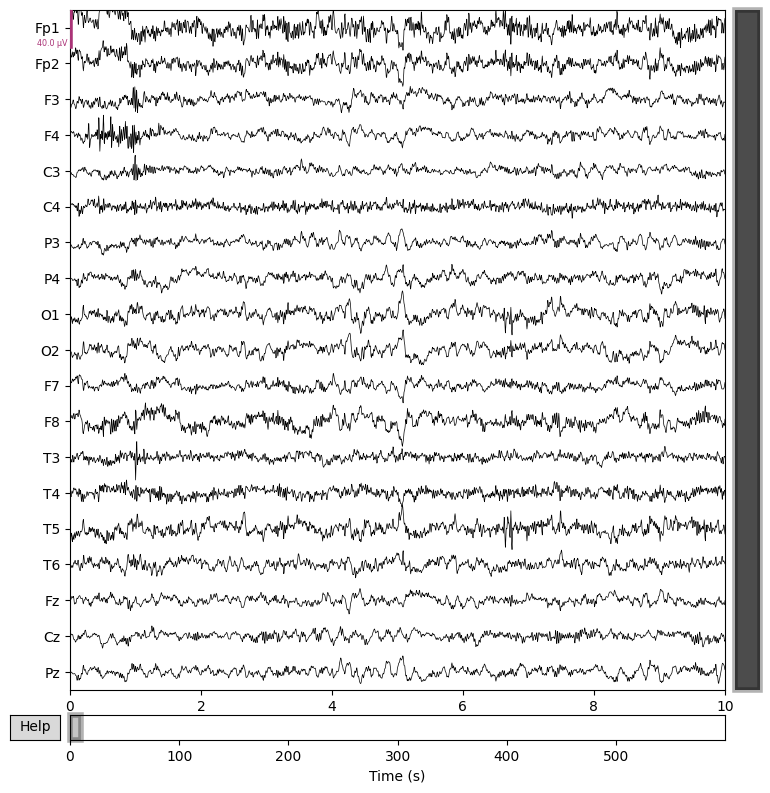

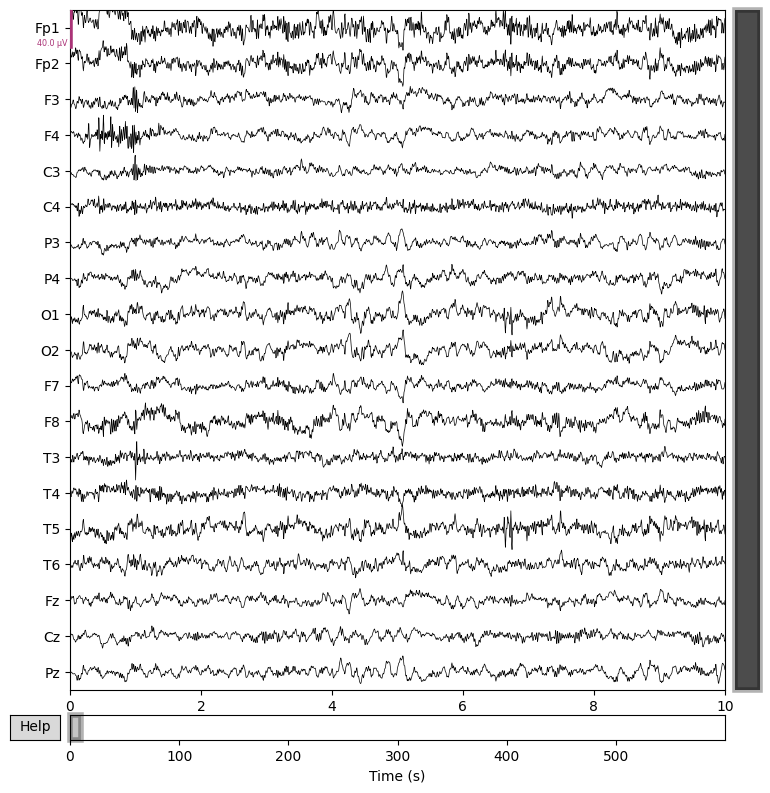

In [7]:
filtered_preprocessed = mne.io.read_raw_fif("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif", preload = True)

print (filtered_preprocessed.info)

filtered_preprocessed.plot()

Feature Extraction Process

First Step in the Feature Extraction Pipeline: Epoching the data

1. Extracting 8-Second Epochs with 50% Overlap

In [8]:
def extract_epochs(raw, epoch_length=8, overlap=0.5):
    """
    Extract 8-second epochs with 50% overlap from the eeg data

    parameters:
    -raw: mne.io
    -epoch_length: length of each epoch in seconds, in this case it is 8 seconds
    -overlap: 50%

    returns:
    -epochs_data: array of shape (n_epochs, n_channels, n_samples)
    
    """
    s_freq = raw.info['sfreq'] #sampling frequency

    samples_per_epoch = int(epoch_length * s_freq)

    step_size = int (samples_per_epoch * (1-overlap))

    #extract data

    data = raw.get_data()
    n_channels, n_samples = data.shape

    #create overlapping epochs

    epochs =  []
    for start in range(0, n_samples - samples_per_epoch + 1, step_size):
        epoch = data[:, start:start + samples_per_epoch] #extracts samples corresponding to the epoch length
        epochs.append(epoch)

    epochs_data = np.array(epochs)
    return epochs_data



LET US START WITH THE FIRST PART, IMPLEMENTING THE EXTRACT EPOCHS FUNCTION AND LOOPING THROUGH MY FIF FILES

In [9]:
data_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short"
output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short"


#looping through data folder

for file_name in os.listdir(data_folder):
    if file_name.endswith(".fif"):
        file_path = os.path.join(data_folder, file_name)

        print(f"Processing {file_name}...")

        #loading the fif preprocessed data

        raw = mne.io.read_raw_fif(file_path, preload=True)

        #calling the extract epoch function

        epochs_data = extract_epochs(raw, epoch_length=8, overlap = 0.5)

        # Save each epoch as a separate file
        subject_id = file_name.split('_')[0]  # Extract subject ID (e.g., sub-001)
        for i, epoch in enumerate(epochs_data):
            epoch_file = os.path.join(output_folder, f"{subject_id}_epoch-{i+1:03d}.npy")
            np.save(epoch_file, epoch)  # Save the epoch as a separate file

        print(f"Saved {len(epochs_data)} epochs for {file_name}")



Processing sub-003_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-003_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 153049 =      0.000 ...   306.098 secs
Ready.
Reading 0 ... 153049  =      0.000 ...   306.098 secs...
Saved 75 epochs for sub-003_task-eyesclosed_eeg_preprocessed.fif
Processing sub-004_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-004_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 353049 =      0.000 ...   706.098 secs
Ready.
Reading 0 ... 353049  =      0.000 ...   706.098 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/4291341890.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-003_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/4291341890.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-004_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.g

Saved 175 epochs for sub-004_task-eyesclosed_eeg_preprocessed.fif
Processing sub-002_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-002_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 396549 =      0.000 ...   793.098 secs
Ready.
Reading 0 ... 396549  =      0.000 ...   793.098 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/4291341890.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-002_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 197 epochs for sub-002_task-eyesclosed_eeg_preprocessed.fif
Processing sub-038_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-038_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 445699 =      0.000 ...   891.398 secs
Ready.
Reading 0 ... 445699  =      0.000 ...   891.398 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/4291341890.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-038_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 221 epochs for sub-038_task-eyesclosed_eeg_preprocessed.fif
Processing sub-039_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-039_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 425039 =      0.000 ...   850.078 secs
Ready.
Reading 0 ... 425039  =      0.000 ...   850.078 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/4291341890.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-039_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 211 epochs for sub-039_task-eyesclosed_eeg_preprocessed.fif
Processing sub-037_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-037_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 388549 =      0.000 ...   777.098 secs
Ready.
Reading 0 ... 388549  =      0.000 ...   777.098 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/4291341890.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-037_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 193 epochs for sub-037_task-eyesclosed_eeg_preprocessed.fif
Processing sub-040_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-040_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 482869 =      0.000 ...   965.738 secs
Ready.
Reading 0 ... 482869  =      0.000 ...   965.738 secs...


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/4291341890.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-040_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved 240 epochs for sub-040_task-eyesclosed_eeg_preprocessed.fif
Processing sub-001_task-eyesclosed_eeg_preprocessed.fif...
Opening raw data file /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif...
    Range : 0 ... 299899 =      0.000 ...   599.798 secs
Ready.
Reading 0 ... 299899  =      0.000 ...   599.798 secs...
Saved 148 epochs for sub-001_task-eyesclosed_eeg_preprocessed.fif


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_48464/4291341890.py:15: RuntimeWarning: This filename (/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/preprocessed_filtered_short/sub-001_task-eyesclosed_eeg_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


In [10]:
#to get to the individual count and total number of epochs

# Initialize counters for AD and Healthy groups
ad_group_count = 0
healthy_group_count = 0

# Loop through all files in the folder
for file_name in os.listdir(output_folder):
    if file_name.endswith('.npy'):  # Process only .npy files
        subject_id = file_name.split('_')[0]  # Extract subject ID (e.g., 'sub-001')
        subject_num = int(subject_id.split('-')[1])  # Extract numerical part of the subject ID

        # Determine group and update counts
        if 1 <= subject_num <= 36:  # AD group
            ad_group_count += 1
        elif 37 <= subject_num <= 65:  # Healthy group
            healthy_group_count += 1

# Print group-level totals
print(f"AD Group: Total epochs: {ad_group_count}")
print(f"Healthy Group: Total epochs: {healthy_group_count}")
print("Total number of epochs", len(os.listdir(output_folder)))  # Total number of epochs


AD Group: Total epochs: 595
Healthy Group: Total epochs: 865
Total number of epochs 1461


Signal Features Pipeline

2. Spectrum Metrics:
Mean
Variance
Interquartile Range
Power Spectral Density

In [11]:
from scipy.signal import welch

Step1: IQR, Mean, and Variance

In [12]:
def compute_basic_statistics(epoch):

    """
    Compute the basic statistics (mean, variance and interquartile range)for each channel in an epoch

    paramters:

    epoch: 2D array of shape (n_channels, n_samples) for one epoch

    returns:
    -stats_features: Dictionary with mean, variance and IQR values for each channel
    
    """
    n_channels = epoch.shape[0]
    stats_features = {}

    for ch_idx in range(n_channels):
        #calculate mean
        mean_value = np.mean(epoch[ch_idx])
        stats_features[f"channel_{ch_idx}_mean"] = mean_value

        #calculate variance
        variance_value = np.var(epoch[ch_idx])
        stats_features[f"channel_{ch_idx}_variance"] = variance_value

        #calculate IQR
        IQR_value = np.percentile(epoch[ch_idx], 75) - np.percentile(epoch[ch_idx], 25)
        stats_features[f"channel_{ch_idx}_IQR"] = IQR_value
    return stats_features


In [13]:
def compute_psd(epoch, sfreq):

    """
    Compute the Power Spectral Density (PSD) for the full frequency range (0.5-45 hz)
    Compute the Power Spectral Density (PSD) for each EEG rhythm in the frequency band

    Parameters:
    -epoch: 2D array of shape (n_channels, n_samples) for one epoch
    -sfreq; sampling frequency

    Returns:
    -psd_features: Dictionary with PSD values for each frequency band and channel   
    
    """

    n_channels, n_samples = epoch.shape
    psd_features = {}

    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 25),
        'gamma': (25, 45),


    }

    for ch_idx in range(n_channels):
        freqs, psd = welch(epoch[ch_idx], fs=sfreq, nperseg=n_samples)

        #extract PSD for the full frequency range
        psd_full_range = np.sum(psd[(freqs >=0.5) & (freqs <=45)])
        psd_features[f"channel_{ch_idx}_psd_full"] = psd_full_range

        #extract PSD for each EEG rhythm (delta, theta, etc)

        for band, (fmin, fmax) in bands.items():
            band_power = np.sum(psd[(freqs >= fmin) & (freqs < fmax)])
            psd_features[f"channel_{ch_idx}_psd_{band}"] = band_power
            
    return psd_features

Step 3: Relative Band Power: This step normalizes the power in each frequency band relative to the total power

In [14]:
def compute_relative_band_power(psd_features, n_channels):

    """
    Compute relative band power in each channel

    Parameters:

    -psd_features: a dictionary of PSD values for each band and channel
    -n_channels: number of EEG channels

    Returns:

    -relative band power: dictionary with relative power for each band and channel
    
    """

    relative_band_power = {}

    for ch_idx in range (n_channels):
        total_power = psd_features[f"channel_{ch_idx}_psd_full"]
        for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
            band_power = psd_features[f"channel_{ch_idx}_psd_{band}"]
            relative_band_power[f"channel_{ch_idx}_relative_{band}"] = band_power / total_power
            
    return relative_band_power

Step4: Combine all these metrics in one function to extract spectrum features

In [15]:
def extract_spectrum_features(epoch, sfreq):

    """
    Extract spectrum features: mean, variance, IQR, PSD and relative band power

    parameters

    epoch: 2D array of shape
    sfreq: sampling frequency

    returns:

    -features: Dictionary of spectrum features for each channel

    """

    n_channels = epoch.shape[0]
    features = {}

    #compute the time-domain metrics (Basic statistics)

    features.update(compute_basic_statistics(epoch))

    #compute psd
    psd_features = compute_psd(epoch, sfreq)
    features.update(psd_features)

    #compute relative band power
    relative_band_power = compute_relative_band_power(psd_features, n_channels)
    features.update(relative_band_power)

    return features

MOVING ON TO THE SECOND PART WHICH IS EXTRACTING SPECTRUM METRICS FROM THE EXTRACTED EPOCHS

In [16]:
spectrum_file_csv = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/spectrum_features_short.csv"
output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short"
spectrum_features = []
sfreq = 500 

#looping through the epochs folder
for epochs_file in os.listdir(output_folder):
    if epochs_file.endswith('.npy'):

        #load the epochs
        epoch_path = os.path.join(output_folder, epochs_file)
        epoch_data = np.load(epoch_path)

        #extract the spectrum features
        features = extract_spectrum_features(epoch_data, sfreq)

        # Add metadata (subject ID and epoch number)
        subject_id = epochs_file.split('_')[0]  # Extract subject ID (e.g., "sub-001")
        epoch_number = epochs_file.split('_')[1].replace('epoch-', '').split('.')[0]# Extract epoch number
        features['subject_id'] = subject_id
        features['epoch_number'] = int(epoch_number)

        #append the features to the list

        spectrum_features.append(features)

#convert the list to dataframe

spectrum_features_df = pd.DataFrame(spectrum_features)

#save to the csv file

spectrum_features_df.to_csv(spectrum_file_csv, index=False)

print(f"Spectrum features saved to {spectrum_file_csv}")




Spectrum features saved to /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/spectrum_features_short.csv


A brief check on the csv data

In [25]:
spectrum_raw_data = pd.read_csv("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/spectrum_features_short.csv")
spectrum_raw_data.head(5)

,channel_0_mean,channel_0_variance,channel_0_IQR,channel_1_mean,channel_1_variance,channel_1_IQR,channel_2_mean,channel_2_variance,channel_2_IQR,channel_3_mean,...,channel_17_relative_alpha,channel_17_relative_beta,channel_17_relative_gamma,channel_18_relative_delta,channel_18_relative_theta,channel_18_relative_alpha,channel_18_relative_beta,channel_18_relative_gamma,subject_id,epoch_number
0,1.203028e-07,6.120565e-12,0.000003,-9.941398e-08,8.486820e-12,0.000004,4.076647e-07,2.930569e-11,0.000007,4.239381e-07,...,0.227546,0.153534,0.107667,0.433046,0.081258,0.177825,0.234842,0.072879,sub-038,162
1,-3.503463e-07,9.441376e-11,0.000013,-8.889088e-07,1.171971e-10,0.000014,-1.813472e-07,6.477942e-11,0.000010,-4.872074e-07,...,0.152293,0.017284,0.009599,0.195636,0.601159,0.190661,0.009969,0.002575,sub-003,35
2,1.187131e-08,3.989287e-11,0.000008,3.588821e-08,3.828821e-11,0.000008,-4.812334e-08,3.025025e-11,0.000008,-2.471878e-08,...,0.390002,0.057303,0.029207,0.170976,0.112838,0.657864,0.046493,0.011722,sub-003,21
3,-1.085889e-08,9.315711e-12,0.000004,-5.409269e-08,1.236095e-11,0.000005,-9.972700e-07,6.111874e-11,0.000009,-6.646718e-07,...,0.420480,0.240612,0.110960,0.315845,0.053838,0.343050,0.226152,0.060875,sub-038,176
4,2.580282e-08,3.168042e-11,0.000006,-1.701181e-07,2.512482e-11,0.000006,-4.341251e-07,6.348084e-11,0.000010,-2.463204e-07,...,0.176951,0.107884,0.058925,0.390242,0.308907,0.151711,0.115081,0.034019,sub-039,187


3. Complexity Metrics: Approximate Entropy,and  Permutation Entropy

Step1: Calculate Approximate Entropy

In [2]:
def compute_apen(signal, m, r_factor):

    """
    Compute Approximate Entropy (ApEn) for a given signal

    Parameters:

    -signal: 1D array, time series data
    -m: int, the embedding dimension (pattern length)
    -r_factor: float, similarity factor as a fraction of the signal's standard deviation

    Returns:
    -Approximate Entropy Value
    
    """

    N = len(signal)
    std_signal = np.std(signal) #compute the standard deviation of the signal
    r = r_factor * std_signal # set the similarity threshold

    #creating embedding vectors of length m and m+1 - the pattern vectors generated with respect to the value of m(pattern length)

    def create_embedding_vectors(data, dimension):
        return np.array([data[i:i + dimension] for i in range(N - dimension +1)]) #the result part is to get the pattern vector slices while, the for loop is to get the number of pattern vectors, for i in range(5-2+1) if d=m=2, N=5
    
    #Compute the phi function for dimension m and m+1

    def phi(embedding_vectors):
        count = 0
        num_vectors = len(embedding_vectors)

        #compare each embedding vector with all subsequent vectors (j > i)
        for i in range(num_vectors):
            for j in range(i+1, num_vectors): #to avoid redundant similarity comparison computation
                distance = np.max(np.abs(embedding_vectors[i] - embedding_vectors[j])) # recall that we compare the similarity via finding maximum of the absolute difference 
                if distance <= r: #recall that if distance is less than the r, the pattern vector is said to be similar
                    count +=1

         #normalize the count by the numebr of comparisons           
        return count/ (num_vectors * (num_vectors -1) / 2)
    
    #embedding vectors for m and m+1
    embedding_vectors_m = create_embedding_vectors(signal, m)
    embedding_vectors_m1 = create_embedding_vectors(signal, m+1)

    #compute phi for m and m+1
    phi_m = phi(embedding_vectors_m)
    phi_m1 = phi(embedding_vectors_m1)

    #computing the approximate entropy
    ApEn = np.log(phi_m + 1e-10) - np.log(phi_m1 + 1e-10)

    return ApEn


Step2: Calculate Permutation Entropy

In [3]:
from itertools import permutations
from collections import Counter

In [4]:
def compute_permutation_entropy(signal, n):
    """
    Compute Permutation Entropy (PermEn) for a given signal

    Parameters:

    -signal: 1D array, the time series data
    -n: int, the embedding dimension (length of ordinal patterns)

    Returns:

    -PermEn: Permutation Entropy Value
    
    """

    N = len(signal)

    #generate all possible ordinal patterns of length n
    ordinal_patterns = list(permutations(range(n)))
    pattern_count = Counter()


    #slide a window of length n over the signal to extract ordinal patterns

    for i in range(N - n + 1):
        window = signal[i:i +n]
        pattern = tuple(np.argsort(window)) #get the ordinal ranking of the window
        pattern_count[pattern] +=1

    #calculate the probabilities of each ordinal pattern
    total_patterns = sum(pattern_count.values())
    probabilities = np.array([pattern_count[pattern]/total_patterns for pattern in ordinal_patterns])

    #compute the shannon entropy of the probabilities
    non_zero_probs = probabilities[probabilities > 0]
    permutation_entropy = -np.sum(non_zero_probs * np.log(non_zero_probs))

    return permutation_entropy


LET'S MOVE ON TO EXTRACTING COMPLEXITY METRICS

In [7]:
#creating a function that combines all the complexity metrics into one

def extract_complexity_metrics(epoch, m, r_factor, tau):
    """
    Extract complexity metrics (ApEn, PermEn) for a given epoch.

    Parameters:
    - epoch: 2D array of shape (n_channels, n_samples), representing EEG data.
    - m: int, embedding dimension for ApEn, SampEn, and MSE.
    - r_factor: float, similarity threshold as a fraction of the signal's standard deviation.
    - tau: int, the maximum scale factor for MSE.

    Returns:
    - features: Dictionary containing all complexity metrics for each channel.
    """
    n_channels = epoch.shape[0]
    features = {}

    # Loop through each channel in the epoch
    for ch in range(n_channels):
        signal = epoch[ch]

        # Compute Approximate Entropy
        features[f'channel_{ch}_approximate_entropy'] = compute_apen(signal, m, r_factor)

        # Compute Permutation Entropy
        features[f'channel_{ch}_permutation_entropy'] = compute_permutation_entropy(signal, n=3)


    return features



In [8]:

from joblib import Parallel, delayed
import time


def process_and_save_epoch(file_path, csv_file, m, r_factor, tau):
    try:
        # Load the epoch data
        print(f"Loading epoch: {file_path}")
        epoch = np.load(file_path)

        # Extract complexity metrics
        start_time = time.time()
        features = extract_complexity_metrics(epoch, m=m, r_factor=r_factor, tau=tau)
        print(f"Metrics extracted for {file_path} in {time.time() - start_time:.2f} seconds")

        # Add metadata (subject ID and epoch number)
        file_name = os.path.basename(file_path)
        subject_id = file_name.split('_')[0]
        epoch_number = file_name.split('_')[1].replace('epoch-', '').replace('.npy', '')
        features['subject_id'] = subject_id
        features['epoch_number'] = int(epoch_number)

        # Write to CSV
        df_features = pd.DataFrame([features])
        with open(csv_file, 'a') as f:
            df_features.to_csv(f, header=f.tell() == 0, index=False)
        print(f"Processed and saved: {file_name}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")


# Parameters for complexity metrics
embedding_dim = 2
similarity_threshold = 0.15
scale_factor = 5

# Paths
output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short"
complexity_csv = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/complexity_features_short.csv"

# Check processed epochs
if os.path.exists(complexity_csv) and os.path.getsize(complexity_csv) > 0:
    processed_epochs = pd.read_csv(complexity_csv)[['subject_id', 'epoch_number']]
    processed_set = set(
        (row['subject_id'], row['epoch_number']) for _, row in processed_epochs.iterrows()
    )
else:
    processed_set = set()

# List files
epoch_files = [
    os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".npy")
]

# Filter files
files_to_process = []
for file_path in epoch_files:
    file_name = os.path.basename(file_path)
    subject_id = file_name.split('_')[0]
    epoch_number = int(file_name.split('_')[1].replace('epoch-', '').replace('.npy', ''))

    if (subject_id, epoch_number) not in processed_set:
        files_to_process.append(file_path)

print(f"{len(files_to_process)} epochs left to process.")

# Process in parallel
Parallel(n_jobs=-1)(
    delayed(process_and_save_epoch)(file, complexity_csv, embedding_dim, similarity_threshold, scale_factor)
    for file in files_to_process
)

print(f"All epochs processed and saved to {complexity_csv}")

126 epochs left to process.
Loading epoch: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short/sub-004_epoch-003.npy
Loading epoch: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short/sub-037_epoch-064.npy
Loading epoch: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short/sub-002_epoch-169.npy
Loading epoch: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short/sub-004_epoch-017.npy
Loading epoch: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short/sub-037_epoch-070.npy
Loading epoch: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short/sub-039_epoch-016.npy
Loading epoch: /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short/sub-002_epoch-141.npy
Loading epoch: /Users/folasewaabdulsalam/Signal_

4. Synchronization Metrics: Clustering Coefficient, characteristic path length, efficiency and small-worldness

To get synchronization metrics, first get the functional connectivity matrix, then threshold the matrix, build the graph and compute the metrics

Step 1: Functional Connectivity Matrix

In [9]:
def connectivity_matrix(epoch, method):
    """
    Compute the functional connectivity matrix for an epoch

    Parameters:
    -epoch: 2D numpy array (n_channels, n_samples_per_epoch)
    -method: synchronization method which can be pearson or phase locking value (plv)

    Returns:
    -connectivity_matrix: 2D numpy (n_channels, n_channels)

    """
    n_channels = epoch.shape[0]
    connectivity_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(n_channels):
            if method == 'pearson': #for pearson method
                connectivity_matrix[i, j] = np.corrcoef(epoch[i, :], epoch[j, :])[0,1]

            elif method == 'plv':
                phase_i = np.angle(np.fft.fft(epoch[i, :])) #extract phases using fast fourier transform
                phase_j = np.angle(np.fft.fft(epoch[j, :]))
                phase_diff = phase_i - phase_j # instantaneous phase difference
                plv = np.abs(np.mean(np.exp(1j * phase_diff)))#plv
                connectivity_matrix[i, j] = plv
            
            else:
                raise ValueError("Invalid method of synchronization, choose either pearson or plv")

    return connectivity_matrix


Step 2: Threshold the connectivity matrix

In [10]:
#convert the functional connectivity matrix into a binary adjacency matrix

def threshold_matrix(connectivity_matrix, threshold ):
    """
    Threshold the functional connectivity matrix

    Parameters:
    -connectivity_matrix : 2D Numpy array (n_channels, n_channels)
    -threshold: proportion of strongest connection to keep (e.g 0.1 for 10%)

    Returns:
    -adjacency_matrix: 2D numpy array , binary matrix (0, 1) 

    """

    n_channels = connectivity_matrix.shape[0]
    #flatten and sort connections
    sorted_values = np.sort(connectivity_matrix.flatten())[::-1]
    cutoff = sorted_values[int(threshold * n_channels * n_channels)]
    
    #apply the threshold
    adjacency_matrix = (connectivity_matrix >=cutoff).astype(int)

    #remove self connections
    np.fill_diagonal(adjacency_matrix, 0)

    return adjacency_matrix
 

Step 3: Build the Graph and compute the graph metrics

In [11]:
import networkx as nx

In [12]:

def compute_graph_metrics(adjacency_matrix, n_swaps = None):
    """
    Compute the graph metrics from the adjacency matrix

    Parameters:
    -adjacency-matrix: 2D numpy array, binary matrix (0s and 1s)
    -n_swaps: nu,ber of edge swaps for null model. If none, defaults to 10 times the number of edges in the observed graphs

    Returns:
    -metrics: dict containing clustering coefficient, characteristic path length, global efficiency and small worldness
    
    """

    G = nx.from_numpy_array(adjacency_matrix)

    #compute the graph metrics
    clustering_coefficient = nx.average_clustering(G)

    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.inf #handle disconnected graphs
    
    global_efficiency = nx.global_efficiency(G)

    #smallworldness = standardized clustering coefficients /  standardized characteristic path length

    #determine n_swaps if not provided
    n_edges = len(G.edges)
    if n_swaps is None:
        n_swaps = 10 * n_edges #default to 10 times th enumber of edges
    
    #create Null Model(shuffle edges)
    G_Null = G.copy()
    nx.double_edge_swap(G_Null, nswap = n_swaps, max_tries=n_swaps*10)

    #Null model metrics
    clustering_coefficient_null = nx.average_clustering(G_Null)

    try:
        path_length_null = nx.average_shortest_path_length(G_Null)
    except nx.NetworkXError:
        path_length_null = np.inf
    
    #compute the standardized metrics (Gamma and Delta)

    gamma = clustering_coefficient / clustering_coefficient_null if clustering_coefficient_null > 0 else 0
    delta = path_length / path_length_null if path_length_null > 0 else np.inf

    small_worldness = gamma/delta if delta > 0 else 0

    #return all the metrics

    metrics = {
        "clustering_coefficient": clustering_coefficient,
        "characteristic_path_length": path_length,
        "global_efficiency": global_efficiency,
        "small_worldness": small_worldness,

    }

    return metrics


Moving on the last part of feature extraction which is Synchronization Feature

In [22]:
def process_and_save_sync_epoch(file_path, csv_file, method, threshold):
    """
    Process a single epoch file, compute graph metrics, and write to a CSV file.

    Parameters:
    - file_path: Path to the .npy epoch file.
    - csv_file: Path to the CSV file to save results incrementally.
    - method: Synchronization method for connectivity matrix ('pearson' or 'plv').
    - threshold: Proportion of strongest connections to keep in adjacency matrix.
    """
    try:
        # Load the epoch data
        epoch = np.load(file_path)

        # Step 1: Compute the connectivity matrix
        connectivity = connectivity_matrix(epoch, method)

        # Step 2: Apply thresholding to create the adjacency matrix
        adjacency = threshold_matrix(connectivity, threshold)

        # Step 3: Compute graph metrics from the adjacency matrix
        metrics = compute_graph_metrics(adjacency)

        # Add metadata (subject ID and epoch number)
        file_name = os.path.basename(file_path)
        subject_id = file_name.split('_')[0]  # Extract subject ID
        epoch_number = file_name.split('_')[1].replace('epoch-', '').replace('.npy', '')  # Extract epoch number
        metrics['subject_id'] = subject_id
        metrics['epoch_number'] = int(epoch_number)

        # Convert metrics to a DataFrame
        df_metrics = pd.DataFrame([metrics])

        # Step 4: Write to the CSV file incrementally (append mode)
        write_header = not os.path.exists(csv_file) or os.path.getsize(csv_file) == 0  # Check if file is empty
        with open(csv_file, 'a') as f:
            df_metrics.to_csv(f, header=write_header, index=False)

        print(f"Processed and saved: {file_name}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [23]:
# Parameters
synchronization_method = "pearson"  # for pearson method
threshold_value = 0.6  # 60% strongest connections
graph_metrics_csv = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/synchronization_features_short.csv"
output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short"  # Path to the folder containing .npy epoch files

# Check if the CSV file exists and is not empty
if os.path.exists(graph_metrics_csv) and os.path.getsize(graph_metrics_csv) > 0:
    processed_epochs = pd.read_csv(graph_metrics_csv)[['subject_id', 'epoch_number']]
    processed_set = set(
        (row['subject_id'], row['epoch_number']) for _, row in processed_epochs.iterrows()
    )
else:
    processed_set = set()

# List all files in the folder
epoch_files = [
    os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".npy")
]

# Filter out already processed files
files_to_process = []
for file_path in epoch_files:
    file_name = os.path.basename(file_path)
    subject_id = file_name.split('_')[0]
    epoch_number = int(file_name.split('_')[1].replace('epoch-', '').replace('.npy', ''))

    if (subject_id, epoch_number) not in processed_set:
        files_to_process.append(file_path)

print(f"{len(files_to_process)} epochs left to process.")

# Process remaining epochs in parallel
Parallel(n_jobs=-1)(
    delayed(process_and_save_sync_epoch)(
        file, graph_metrics_csv, synchronization_method, threshold_value
    )
    for file in files_to_process
)

print(f"All epochs processed and saved to {graph_metrics_csv}.")


1460 epochs left to process.
Processed and saved: sub-038_epoch-162.npy
Processed and saved: sub-003_epoch-035.npy
Processed and saved: sub-038_epoch-176.npy
Processed and saved: sub-039_epoch-187.npy
Processed and saved: sub-003_epoch-021.npy
Processed and saved: sub-003_epoch-009.npy
Processed and saved: sub-039_epoch-178.npy
Processed and saved: sub-039_epoch-193.npy
Processed and saved: sub-004_epoch-151.npy
Processed and saved: sub-037_epoch-122.npy
Processed and saved: sub-004_epoch-145.npy
Processed and saved: sub-037_epoch-136.npy
Processed and saved: sub-039_epoch-144.npy
Processed and saved: sub-002_epoch-013.npy
Processed and saved: sub-002_epoch-007.npy
Processed and saved: sub-039_epoch-150.npy
Processed and saved: sub-038_epoch-189.npy
Processed and saved: sub-038_epoch-214.npy
Processed and saved: sub-040_epoch-086.npy
Processed and saved: sub-001_epoch-016.npy
Processed and saved: sub-040_epoch-119.npy
Processed and saved: sub-037_epoch-081.npy
Processed and saved: sub-

In [24]:
sync_data = pd.read_csv("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/synchronization_features_short.csv")
sync_data.head(5)

,clustering_coefficient,characteristic_path_length,global_efficiency,small_worldness,subject_id,epoch_number
0,0.659877,1.421053,0.789474,1.150774,sub-038,162
1,0.696795,1.421053,0.789474,1.264644,sub-003,35
2,0.704497,1.421053,0.789474,1.269164,sub-038,176
3,0.669211,1.421053,0.789474,1.251785,sub-039,187
4,0.698618,1.426901,0.788499,1.352919,sub-003,21


CLASSIFICATION MODEL BUILDING

In [62]:
#import the libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix

In [26]:
complexity_raw_data = pd.read_csv("/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/complexity_features_short.csv")
complexity_raw_data.head(5)

,channel_0_approximate_entropy,channel_0_permutation_entropy,channel_1_approximate_entropy,channel_1_permutation_entropy,channel_2_approximate_entropy,channel_2_permutation_entropy,channel_3_approximate_entropy,channel_3_permutation_entropy,channel_4_approximate_entropy,channel_4_permutation_entropy,...,channel_15_approximate_entropy,channel_15_permutation_entropy,channel_16_approximate_entropy,channel_16_permutation_entropy,channel_17_approximate_entropy,channel_17_permutation_entropy,channel_18_approximate_entropy,channel_18_permutation_entropy,subject_id,epoch_number
0,0.464111,1.068980,0.484137,1.050722,0.520825,1.063838,0.515820,1.050303,0.526063,1.006796,...,0.522239,0.929906,0.514182,1.042540,0.530537,1.047826,0.489394,0.980259,sub-003,21
1,0.439854,1.035168,0.484185,1.080236,0.487552,1.104106,0.522052,1.122239,0.519750,1.075827,...,0.412723,1.081766,0.536398,1.137031,0.478033,1.120015,0.472556,1.058486,sub-039,187
2,0.456321,0.993892,0.425017,0.984354,0.453703,1.026546,0.410592,1.016929,0.428417,0.968421,...,0.466608,0.934400,0.448629,0.984303,0.406822,1.000789,0.389960,0.919677,sub-003,35
3,0.509750,1.064913,0.516760,1.107717,0.536769,1.123093,0.556499,1.131172,0.563663,1.099381,...,0.569306,1.121397,0.539533,1.146301,0.468507,1.094040,0.539109,1.072145,sub-039,178
4,0.577542,1.087407,0.601008,1.118511,0.588058,1.094810,0.563701,1.123946,0.614888,1.097101,...,0.518541,1.050367,0.580393,1.083192,0.590178,1.091944,0.586761,1.090300,sub-038,162


In [28]:
spectrum_raw_data.head(5)

,channel_0_mean,channel_0_variance,channel_0_IQR,channel_1_mean,channel_1_variance,channel_1_IQR,channel_2_mean,channel_2_variance,channel_2_IQR,channel_3_mean,...,channel_17_relative_alpha,channel_17_relative_beta,channel_17_relative_gamma,channel_18_relative_delta,channel_18_relative_theta,channel_18_relative_alpha,channel_18_relative_beta,channel_18_relative_gamma,subject_id,epoch_number
0,1.203028e-07,6.120565e-12,0.000003,-9.941398e-08,8.486820e-12,0.000004,4.076647e-07,2.930569e-11,0.000007,4.239381e-07,...,0.227546,0.153534,0.107667,0.433046,0.081258,0.177825,0.234842,0.072879,sub-038,162
1,-3.503463e-07,9.441376e-11,0.000013,-8.889088e-07,1.171971e-10,0.000014,-1.813472e-07,6.477942e-11,0.000010,-4.872074e-07,...,0.152293,0.017284,0.009599,0.195636,0.601159,0.190661,0.009969,0.002575,sub-003,35
2,1.187131e-08,3.989287e-11,0.000008,3.588821e-08,3.828821e-11,0.000008,-4.812334e-08,3.025025e-11,0.000008,-2.471878e-08,...,0.390002,0.057303,0.029207,0.170976,0.112838,0.657864,0.046493,0.011722,sub-003,21
3,-1.085889e-08,9.315711e-12,0.000004,-5.409269e-08,1.236095e-11,0.000005,-9.972700e-07,6.111874e-11,0.000009,-6.646718e-07,...,0.420480,0.240612,0.110960,0.315845,0.053838,0.343050,0.226152,0.060875,sub-038,176
4,2.580282e-08,3.168042e-11,0.000006,-1.701181e-07,2.512482e-11,0.000006,-4.341251e-07,6.348084e-11,0.000010,-2.463204e-07,...,0.176951,0.107884,0.058925,0.390242,0.308907,0.151711,0.115081,0.034019,sub-039,187


In [30]:
#combining all the csv files to form one dataset
combined_data = pd.merge(spectrum_raw_data, complexity_raw_data, on = ['subject_id', 'epoch_number'])
raw_data_all = pd.merge(combined_data, sync_data, on = ['subject_id', 'epoch_number']) 

In [31]:
raw_data_all.head(5)

,channel_0_mean,channel_0_variance,channel_0_IQR,channel_1_mean,channel_1_variance,channel_1_IQR,channel_2_mean,channel_2_variance,channel_2_IQR,channel_3_mean,...,channel_16_approximate_entropy,channel_16_permutation_entropy,channel_17_approximate_entropy,channel_17_permutation_entropy,channel_18_approximate_entropy,channel_18_permutation_entropy,clustering_coefficient,characteristic_path_length,global_efficiency,small_worldness
0,1.203028e-07,6.120565e-12,0.000003,-9.941398e-08,8.486820e-12,0.000004,4.076647e-07,2.930569e-11,0.000007,4.239381e-07,...,0.580393,1.083192,0.590178,1.091944,0.586761,1.090300,0.659877,1.421053,0.789474,1.150774
1,-3.503463e-07,9.441376e-11,0.000013,-8.889088e-07,1.171971e-10,0.000014,-1.813472e-07,6.477942e-11,0.000010,-4.872074e-07,...,0.448629,0.984303,0.406822,1.000789,0.389960,0.919677,0.696795,1.421053,0.789474,1.264644
2,1.187131e-08,3.989287e-11,0.000008,3.588821e-08,3.828821e-11,0.000008,-4.812334e-08,3.025025e-11,0.000008,-2.471878e-08,...,0.514182,1.042540,0.530537,1.047826,0.489394,0.980259,0.698618,1.426901,0.788499,1.352919
3,-1.085889e-08,9.315711e-12,0.000004,-5.409269e-08,1.236095e-11,0.000005,-9.972700e-07,6.111874e-11,0.000009,-6.646718e-07,...,0.585963,1.071530,0.615878,1.087033,0.583496,1.068052,0.704497,1.421053,0.789474,1.269164
4,2.580282e-08,3.168042e-11,0.000006,-1.701181e-07,2.512482e-11,0.000006,-4.341251e-07,6.348084e-11,0.000010,-2.463204e-07,...,0.536398,1.137031,0.478033,1.120015,0.472556,1.058486,0.669211,1.421053,0.789474,1.251785


In [34]:
#creating a new column titled label 0 for CN, 1 for AZ
#AD Group: Sub 001 to sub 036
#CN Group: Sub 037 to sub 065

def assign_label(subject_id):
    subject_num = int(subject_id.split('-')[1])
    if subject_num in range(1,5):
        return 1
    elif subject_num in range(37, 41):
        return 0
    else:
        return None



raw_data_all['label'] = raw_data_all['subject_id'].apply(assign_label)

raw_data_all.to_csv('project_data.csv', index=False) #to save the updated data

In [35]:
raw_data_all.columns


Index(['channel_0_mean', 'channel_0_variance', 'channel_0_IQR',
       'channel_1_mean', 'channel_1_variance', 'channel_1_IQR',
       'channel_2_mean', 'channel_2_variance', 'channel_2_IQR',
       'channel_3_mean',
       ...
       'channel_16_permutation_entropy', 'channel_17_approximate_entropy',
       'channel_17_permutation_entropy', 'channel_18_approximate_entropy',
       'channel_18_permutation_entropy', 'clustering_coefficient',
       'characteristic_path_length', 'global_efficiency', 'small_worldness',
       'label'],
      dtype='object', length=311)

In [41]:
X = raw_data_all.drop(['label', 'subject_id', 'epoch_number'], axis = 1)
y = raw_data_all['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


In [65]:
#functions for model building
def train_evaluate_decision_tree(X_train, X_test, y_train, y_test):

    print("\n.....training and evaluating with Decision Tree....")
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    accuracy =accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn/(tn+fp)

    #printing these metrics
    print("Decision Tree Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return dt_model

def train_evaluate_random_forest(X_train, X_test, y_train, y_test):

    print("\n ... training and evaluating with Random Forest ...")

    rf_model = RandomForestClassifier(n_estimators= 100, 
                                      max_depth=10,
                                      min_samples_split=5,
                                      min_samples_leaf=2,
                                      random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy =accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn/(tn+fp)

    #printing these metrics
    print("Random Forest Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return rf_model

def train_evaluate_svm(X_train, X_test, y_train, y_test):

    print("\n...training and evaluating with svm ...")

    svm_model = SVC(random_state=42, kernel="linear")
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    accuracy =accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn/(tn+fp)
    

    #printing these metrics
    print("SVM  Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    

    return svm_model


In [66]:
dt_model = train_evaluate_decision_tree(X_train, X_test, y_train, y_test)
rf_model = train_evaluate_random_forest(X_train, X_test, y_train, y_test)



.....training and evaluating with Decision Tree....
Decision Tree Performance Metrics:
Accuracy: 0.9130
Sensitivity (Recall): 0.9030
Specificity: 0.9199

 ... training and evaluating with Random Forest ...
Random Forest Performance Metrics:
Accuracy: 0.9879
Sensitivity (Recall): 0.9747
Specificity: 0.9971


In [51]:
svm_model = train_evaluate_svm(X_train, X_test, y_train, y_test)


...training and evaluating with svm ...
SVM  Performance Metrics:
Accuracy: 0.9724
Sensitivity (Recall): 0.9726
Specificity: 0.9723


CROSS VALIDATION USING GroupShuffleSplit

In [70]:
from sklearn.model_selection import GroupShuffleSplit


# Features and labels
features = raw_data_all.drop(['label', 'subject_id', 'epoch_number'], axis=1)
label_column = 'label'
X = features
y = raw_data_all[label_column]
groups = raw_data_all['subject_id']


## Initialize dictionaries to store metrics for each model
dt_metrics = {'accuracy': [], 'sensitivity': [], 'specificity': []}
rf_metrics = {'accuracy': [], 'sensitivity': [], 'specificity': []}
svm_metrics = {'accuracy': [], 'sensitivity': [], 'specificity': []}

# GroupShuffleSplit instance
group_splitter = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Iterate through the splits
for fold_idx, (train_idx, test_idx) in enumerate(group_splitter.split(X, y, groups=groups)):
    # Split data into train and test sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ensure both classes are present in the test set
    if len(y_test.unique()) < 2:
        print(f"Skipping Fold {fold_idx + 1}: Test set does not contain both classes.")
        continue

    print(f"\n--- Fold {fold_idx + 1} ---")

    # Decision Tree
    dt_model = train_evaluate_decision_tree(X_train, X_test, y_train, y_test)
    dt_metrics['accuracy'].append(accuracy_score(y_test, dt_model.predict(X_test)))
    dt_metrics['sensitivity'].append(recall_score(y_test, dt_model.predict(X_test), pos_label=1))
    tn, fp, fn, tp = confusion_matrix(y_test, dt_model.predict(X_test)).ravel()
    dt_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Random Forest
    rf_model = train_evaluate_random_forest(X_train, X_test, y_train, y_test)
    rf_metrics['accuracy'].append(accuracy_score(y_test, rf_model.predict(X_test)))
    rf_metrics['sensitivity'].append(recall_score(y_test, rf_model.predict(X_test), pos_label=1))
    tn, fp, fn, tp = confusion_matrix(y_test, rf_model.predict(X_test)).ravel()
    rf_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # SVM
    svm_model = train_evaluate_svm(X_train, X_test, y_train, y_test)
    svm_metrics['accuracy'].append(accuracy_score(y_test, svm_model.predict(X_test)))
    svm_metrics['sensitivity'].append(recall_score(y_test, svm_model.predict(X_test), pos_label=1))
    tn, fp, fn, tp = confusion_matrix(y_test, svm_model.predict(X_test)).ravel()
    svm_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

# Print Average Metrics Across All Folds
print("\n--- Average Metrics Across All Folds ---")

# Decision Tree
print("Decision Tree:")
print(f"Average Accuracy: {sum(dt_metrics['accuracy']) / len(dt_metrics['accuracy']):.4f}")
print(f"Average Sensitivity: {sum(dt_metrics['sensitivity']) / len(dt_metrics['sensitivity']):.4f}")
print(f"Average Specificity: {sum(dt_metrics['specificity']) / len(dt_metrics['specificity']):.4f}")

# Random Forest
print("\nRandom Forest:")
print(f"Average Accuracy: {sum(rf_metrics['accuracy']) / len(rf_metrics['accuracy']):.4f}")
print(f"Average Sensitivity: {sum(rf_metrics['sensitivity']) / len(rf_metrics['sensitivity']):.4f}")
print(f"Average Specificity: {sum(rf_metrics['specificity']) / len(rf_metrics['specificity']):.4f}")

# SVM
print("\nSVM:")
print(f"Average Accuracy: {sum(svm_metrics['accuracy']) / len(svm_metrics['accuracy']):.4f}")
print(f"Average Sensitivity: {sum(svm_metrics['sensitivity']) / len(svm_metrics['sensitivity']):.4f}")
print(f"Average Specificity: {sum(svm_metrics['specificity']) / len(svm_metrics['specificity']):.4f}")




--- Fold 1 ---

.....training and evaluating with Decision Tree....
Decision Tree Performance Metrics:
Accuracy: 0.5666
Sensitivity (Recall): 0.1675
Specificity: 0.9306

 ... training and evaluating with Random Forest ...
Random Forest Performance Metrics:
Accuracy: 0.5569
Sensitivity (Recall): 0.0761
Specificity: 0.9954

...training and evaluating with svm ...
SVM  Performance Metrics:
Accuracy: 0.5496
Sensitivity (Recall): 0.0812
Specificity: 0.9769

--- Fold 2 ---

.....training and evaluating with Decision Tree....
Decision Tree Performance Metrics:
Accuracy: 0.5835
Sensitivity (Recall): 0.4343
Specificity: 0.6933

 ... training and evaluating with Random Forest ...
Random Forest Performance Metrics:
Accuracy: 0.9467
Sensitivity (Recall): 0.9943
Specificity: 0.9118

...training and evaluating with svm ...
SVM  Performance Metrics:
Accuracy: 0.8160
Sensitivity (Recall): 1.0000
Specificity: 0.6807

--- Fold 3 ---

.....training and evaluating with Decision Tree....
Decision Tree Per

VISUALIZATION PART

Implement the brain network analysis

First analysis: Correlation Matrix

In [152]:
import seaborn as sns
from mne.io import read_raw_eeglab

In [153]:
def compute_correlation_matrix(file_path):
    """
    Compute the correlation matrix for all pairs of electrodes in a .set file.

    Parameters:
    - file_path: Path to the .set file.

    Returns:
    - correlation_matrix: 2D numpy array (n_channels x n_channels).
    - channel_names: List of electrode names.
    """
    # Load the raw EEG data
    raw = read_raw_eeglab(file_path, preload=True)

    # Extract EEG data (channels x samples)
    data = raw.get_data()

    # Get channel names
    channel_names = raw.ch_names

    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(data)

    return correlation_matrix, channel_names

In [154]:
def plot_connectivity_matrix(correlation_matrix, channel_names, title, save_path):
    """
    Plot a heatmap of the correlation (connectivity) matrix and save it.

    Parameters:
    - correlation_matrix: 2D numpy array, functional connectivity matrix.
    - channel_names: List of strings, names of EEG channels.
    - title: Title for the heatmap.
    - save_path: Path to save the heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        xticklabels=channel_names,
        yticklabels=channel_names,
        cmap="coolwarm",
        cbar=True
    )
    plt.title(title)
    plt.xlabel("Channels")
    plt.ylabel("Channels")

    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.close()

In [155]:
def process_all_set_files(input_folder, output_folder):
    """
    Process all .set files in a folder, compute connectivity, and save heatmaps.

    Parameters:
    - input_folder: Path to the folder containing .set files.
    - output_folder: Path to save the heatmaps.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List all .set files in the folder
    set_files = [f for f in os.listdir(input_folder) if f.endswith('.set')]

    print(f"Found {len(set_files)} .set files to process.")

    for file_name in set_files:
        file_path = os.path.join(input_folder, file_name)

        try:
            # Compute correlation matrix
            correlation_matrix, channel_names = compute_correlation_matrix(file_path)

            # Save the plot
            subject_id = os.path.splitext(file_name)[0]  # Extract filename without extension
            save_path = os.path.join(output_folder, f"{subject_id}_connectivity_matrix.png")
            plot_connectivity_matrix(
                correlation_matrix,
                channel_names,
                title=f"Connectivity Matrix: {subject_id}",
                save_path=save_path
            )
            print(f"Processed and saved connectivity matrix for {subject_id}")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

In [156]:

if __name__ == "__main__":
    input_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/filtered_subjects_short" # set files
    output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/subject-level-heatmap"  # heatmap folder

    process_all_set_files(input_folder, output_folder)




Found 8 .set files to process.


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_1288/1186035478.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(file_path, preload=True)


Processed and saved connectivity matrix for sub-040_task-eyesclosed_eeg


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_1288/1186035478.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(file_path, preload=True)


Processed and saved connectivity matrix for sub-004_task-eyesclosed_eeg


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_1288/1186035478.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(file_path, preload=True)


Processed and saved connectivity matrix for sub-039_task-eyesclosed_eeg


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_1288/1186035478.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(file_path, preload=True)


Processed and saved connectivity matrix for sub-003_task-eyesclosed_eeg
Processed and saved connectivity matrix for sub-001_task-eyesclosed_eeg
Processed and saved connectivity matrix for sub-002_task-eyesclosed_eeg


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_1288/1186035478.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(file_path, preload=True)


Processed and saved connectivity matrix for sub-038_task-eyesclosed_eeg
Processed and saved connectivity matrix for sub-037_task-eyesclosed_eeg


Second Analysis: BRAIN NETWORK ANALYSIS - VISUALIIZE THE BRAIN ANALYSIS NETWORK

In [140]:
import eeg_positions

from eeg_positions import get_elec_coords

def get_mne_sensor_positions(channel_names):
    """
    Get MNE sensor positions for the given channel names.

    Parameters:
    - channel_names: List of channel names (e.g., ['Fp1', 'Fp2', ...]).

    Returns:
    - pos: Dictionary with channel names as keys and 2D positions as values.
    """
    # Create MNE info object to generate positions
    info = mne.create_info(ch_names=channel_names, sfreq=250, ch_types="eeg")

    # Get 2D sensor positions from the MNE layout
    montage = mne.channels.make_standard_montage("standard_1020")
    info.set_montage(montage)

    # Extract positions
    pos = {ch: info['chs'][i]['loc'][:2] for i, ch in enumerate(channel_names)}
    return pos

In [141]:


def visualize_brain_network_weighted(connectivity_matrix, channel_names, save_path=None, title="Brain Network Analysis"):
    """
    Visualize the brain network using weighted edges from the connectivity matrix.

    Parameters:
    - connectivity_matrix: 2D numpy array, functional connectivity matrix (weighted).
    - channel_names: List of strings, names of EEG channels.
    - save_path: Path to save the visualization.
    - title: Title for the plot.

    Returns:
    - None
    """
    # Create a weighted graph from the connectivity matrix
    G = nx.from_numpy_array(connectivity_matrix)

    # Map node indices to channel names
    mapping = {i: name for i, name in enumerate(channel_names)}
    G = nx.relabel_nodes(G, mapping)

    # Get MNE sensor positions
    pos = get_mne_sensor_positions(channel_names)

    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, "weight")
    max_weight = max(weights.values())
    normalized_weights = {edge: weight / max_weight for edge, weight in weights.items()}

    # Draw the graph
    plt.figure(figsize=(10, 10))
    edge_colors = list(normalized_weights.values())
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_colors,
        edge_cmap=plt.cm.plasma,  # Use a colormap for edge colors
        edge_vmin=0,
        edge_vmax=1,  # Normalize edge weights for colormap
        width=[w * 5 for w in normalized_weights.values()]  # Scale edge thickness
    )
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=800,
        node_color="skyblue"
    )
    nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_weight="bold"
    )

    # Add color bar for edge weights
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.8)  # Explicitly associate with the current Axes
    cbar.set_label("Normalized Connection Strength", rotation=270, labelpad=20)

    plt.title(title)

    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()  # Close the plot to free memory
    else:
        plt.show()

In [142]:
def process_subject_brain_network(subject_id, epoch_folder, output_folder, channel_names, method='pearson'):
    """
    Process combined epochs for a subject to compute and save the brain network visualization.
    """
    try:
        # Combine all epochs for the subject
        combined_epoch = combine_epochs_for_subject(subject_id, epoch_folder)

        # Compute connectivity matrix (weighted)
        connectivity = connectivity_matrix(combined_epoch, method=method)

        # Define save path for the brain network visualization
        save_path = os.path.join(output_folder, f"{subject_id}_brain_network.png")

        # Visualize and save the brain network using the weighted connectivity matrix
        visualize_brain_network_weighted(
            connectivity,
            channel_names,
            save_path=save_path,
            title=f"Brain Network: {subject_id}"
        )
        print(f"Saved brain network for {subject_id}")
    except Exception as e:
        print(f"Error processing subject {subject_id}: {e}")

In [143]:
def process_all_subjects_brain_networks(epoch_folder, output_folder, channel_names, method='pearson', n_jobs=-1):
    """
    Process combined epochs for all subjects to compute and save brain network visualizations.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # Create output folder if it doesn't exist

    # Extract unique subject IDs from the files in the folder
    subject_ids = set(
        file_name.split('_')[0] for file_name in os.listdir(epoch_folder) if file_name.endswith('.npy')
    )

    print(f"Found {len(subject_ids)} subjects to process.")

    # Process each subject in parallel
    Parallel(n_jobs=n_jobs)(
        delayed(process_subject_brain_network)(subject_id, epoch_folder, output_folder, channel_names, method)
        for subject_id in subject_ids
    )

    print(f"All brain network visualizations saved to {output_folder}")

In [144]:
if __name__ == "__main__":
    # Define paths and parameters
    epoch_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short"
    output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/subject-level-brain-network-visuals"
    channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
    method = 'pearson'  # or 'plv'
    
    # Process all subjects and save brain network visualizations
    process_all_subjects_brain_networks(epoch_folder, output_folder, channel_names, method=method, n_jobs=-1)

Found 8 subjects to process.


Saved brain network for sub-003
Saved brain network for sub-001
Saved brain network for sub-004
Saved brain network for sub-037
Saved brain network for sub-002
Saved brain network for sub-039
Saved brain network for sub-038
Saved brain network for sub-040
All brain network visualizations saved to /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/subject-level-brain-network-visuals


In [149]:
def visualize_brain_network_with_layout(connectivity_matrix, pos, channel_names, save_path=None, title="Brain Network Analysis"):
    """
    Visualize the brain network using weighted edges from the connectivity matrix and EEG layout.

    Parameters:
    - connectivity_matrix: 2D numpy array, functional connectivity matrix (weighted).
    - pos: Dictionary of channel positions obtained from the montage.
    - channel_names: List of strings, names of EEG channels.
    - save_path: Path to save the visualization.
    - title: Title for the plot.

    Returns:
    - None
    """
    # Create a weighted graph from the connectivity matrix
    G = nx.from_numpy_array(connectivity_matrix)

    # Map node indices to channel names
    mapping = {i: name for i, name in enumerate(channel_names)}
    G = nx.relabel_nodes(G, mapping)

    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, "weight")
    max_weight = max(weights.values())
    normalized_weights = {edge: weight / max_weight for edge, weight in weights.items()}

    # Draw the graph
    plt.figure(figsize=(10, 10))
    edge_colors = list(normalized_weights.values())
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_colors,
        edge_cmap=plt.cm.plasma,  # Use a colormap for edge colors
        edge_vmin=0,
        edge_vmax=1,  # Normalize edge weights for colormap
        width=[w * 5 for w in normalized_weights.values()]  # Scale edge thickness
    )
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=800,
        node_color="skyblue"
    )
    nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_weight="bold"
    )

    # Add color bar for edge weights
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.8)  # Explicitly associate with the current Axes
    cbar.set_label("Normalized Connection Strength", rotation=270, labelpad=20)

    plt.title(title)

    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()  # Close the plot to free memory
    else:
        plt.show()

# Processing a single subject with layout
def process_subject_brain_network_with_layout(subject_id, epoch_folder, output_folder, montage, channel_names, method='pearson'):
    """
    Process combined epochs for a subject to compute and save the brain network visualization with sensor layout.

    Parameters:
    - subject_id: ID of the subject (e.g., "sub-001").
    - epoch_folder: Path to the folder containing epoch files.
    - output_folder: Path to save the visualizations.
    - montage: MNE montage object for EEG channel positions.
    - channel_names: List of channel names.
    - method: Method to compute connectivity ('pearson' or 'plv').
    """
    try:
        # Combine all epochs for the subject
        combined_epoch = combine_epochs_for_subject(subject_id, epoch_folder)

        # Compute connectivity matrix (weighted)
        connectivity = connectivity_matrix(combined_epoch, method=method)

        # Get channel positions from the montage
        pos = {ch: montage.get_positions()["ch_pos"][ch][:2] for ch in channel_names}

        # Define save path for the brain network visualization
        save_path = os.path.join(output_folder, f"{subject_id}_brain_network_with_layout.png")

        # Visualize and save the brain network using the weighted connectivity matrix and sensor layout
        visualize_brain_network_with_layout(
            connectivity,
            pos,
            channel_names,
            save_path=save_path,
            title=f"Brain Network: {subject_id}"
        )
        print(f"Saved brain network for {subject_id}")
    except Exception as e:
        print(f"Error processing subject {subject_id}: {e}")

def process_all_subjects_brain_networks(epoch_folder, output_folder, channel_names, method='pearson', n_jobs=-1):
    """
    Process combined epochs for all subjects to compute and save brain network visualizations.

    Parameters:
    - epoch_folder: Path to folder containing .npy epoch files.
    - output_folder: Path to save the visualizations.
    - channel_names: List of channel names.
    - method: Method to compute connectivity ('pearson' or 'plv').
    - n_jobs: Number of parallel jobs (-1 to use all available cores).
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # Create output folder if it doesn't exist

    # Extract unique subject IDs from the files in the folder
    subject_ids = set(
        file_name.split('_')[0] for file_name in os.listdir(epoch_folder) if file_name.endswith('.npy')
    )

    print(f"Found {len(subject_ids)} subjects to process.")

    # Process each subject in parallel
    Parallel(n_jobs=n_jobs)(
        delayed(process_subject_brain_network)(subject_id, epoch_folder, output_folder, channel_names, method)
        for subject_id in subject_ids
    )

    print(f"All brain network visualizations saved to {output_folder}")

if __name__ == "__main__":
    # Define paths and parameters
    epoch_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/epochs_overlap_short"
    output_folder = "/Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/subject-level-brain-network-visuals"
    channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
    method = 'pearson'  # or 'plv'
    
    # Process all subjects and save brain network visualizations
    process_all_subjects_brain_networks(epoch_folder, output_folder, channel_names, method=method, n_jobs=-1)


Found 8 subjects to process.
Figure(640x640)
Figure(640x640)
Saved brain network for sub-003 and sensor layout
Figure(640x640)
Figure(640x640)
Figure(640x640)
Figure(640x640)
Figure(640x640)
Saved brain network for sub-001 and sensor layout
Figure(640x640)
Saved brain network for sub-004 and sensor layout
Saved brain network for sub-037 and sensor layout
Saved brain network for sub-002 and sensor layout
Saved brain network for sub-039 and sensor layout
Saved brain network for sub-038 and sensor layout
Saved brain network for sub-040 and sensor layout
All brain network visualizations saved to /Users/folasewaabdulsalam/Signal_Processing/DS_Alzheimer_Project_Folasewa/subject-level-brain-network-visuals
